# Brain MRI Segmentation

In [310]:
import scipy.io
import matplotlib.pyplot as plt
import utils


data = scipy.io.loadmat('Brain.mat')
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

(362, 434, 10)
(362, 434, 10)
5
0


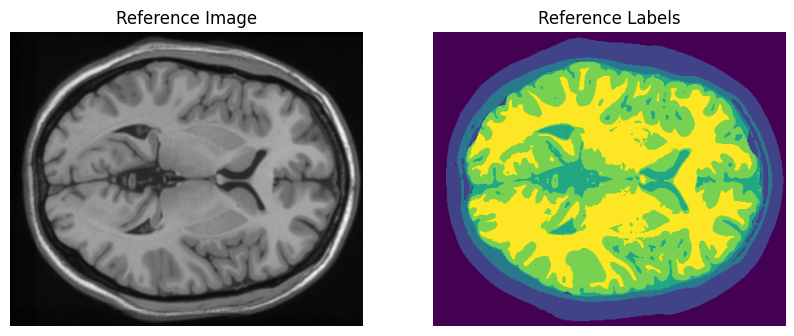

In [311]:
reference_img = mri_stacked[:,:,0]

# Normalize reference_img
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = reference_labels = mri_labels[:,:,0]


utils.plot_images([reference_img,reference_labels], 
            ['Reference Image', 'Reference Labels'],
            ['gray', 'viridis'])

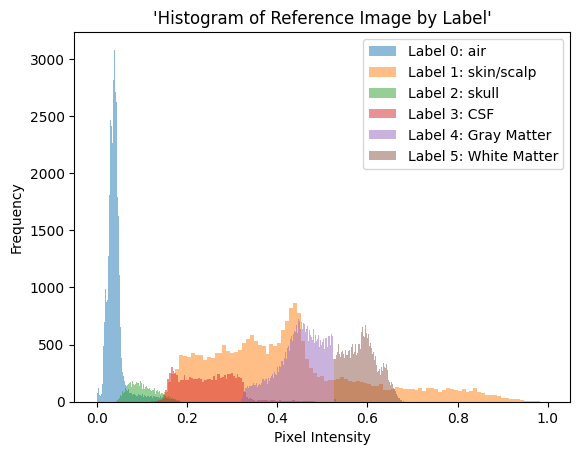

In [312]:
utils.plot_frequencies(reference_img, reference_labels)

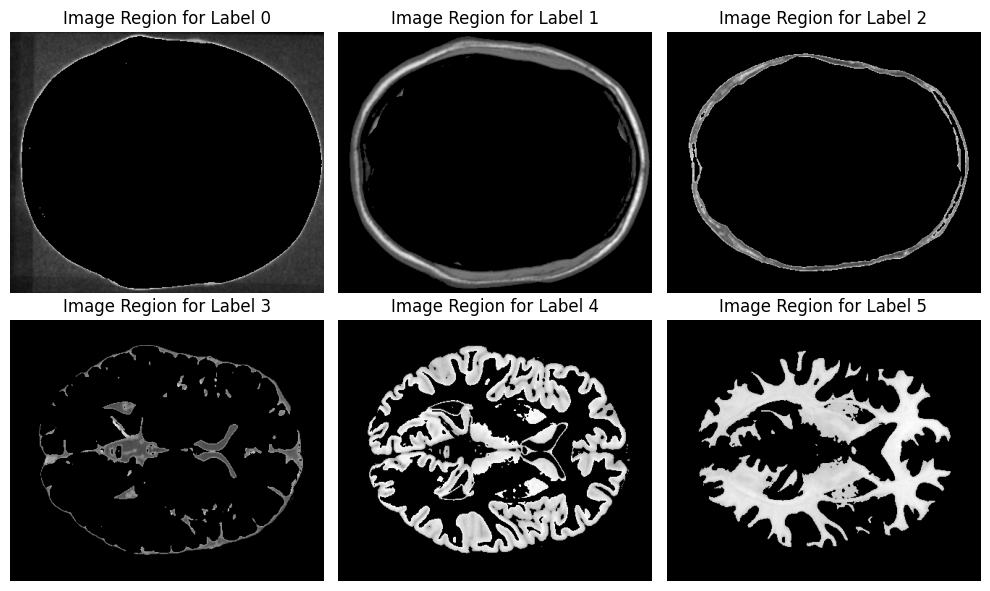

In [313]:
utils.plot_segmented_regions(reference_img, reference_labels)

# Segmentation Algorithm

In [314]:
# Relevant Libraries
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes
import scipy.ndimage as ndimage
from skimage.morphology import convex_hull_image
from sklearn.cluster import KMeans
import numpy as np

from skimage.feature import canny
from skimage.morphology import binary_opening, binary_closing, disk

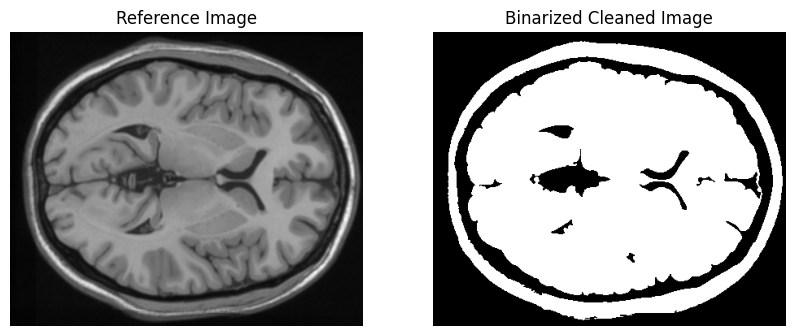

In [315]:
reference_img = mri_stacked[:,:,0]

# Normalize reference_img
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

temporal_masks = {}

def binarizing_cleaning(reference_img):
    # Apply an outsu algorithm to the reference image
    threshold = threshold_otsu(reference_img)
    binary = reference_img > threshold - 0.02

    # Remove the smaller artificts (holes and objects)
    cleaned = remove_small_holes(binary)
    cleaned = remove_small_objects(cleaned, min_size=1000)

    return cleaned

cleaned = binarizing_cleaning(reference_img)

# Plot temporal masks
utils.plot_images([reference_img, cleaned],[ 'Reference Image', 'Binarized Cleaned Image'])

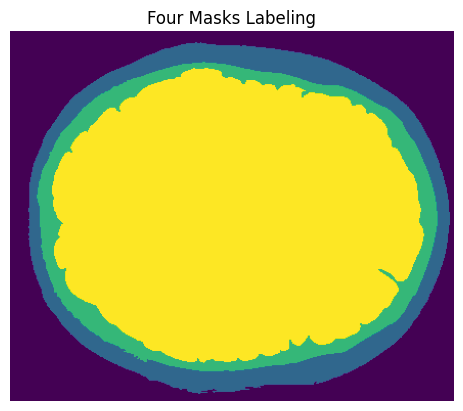

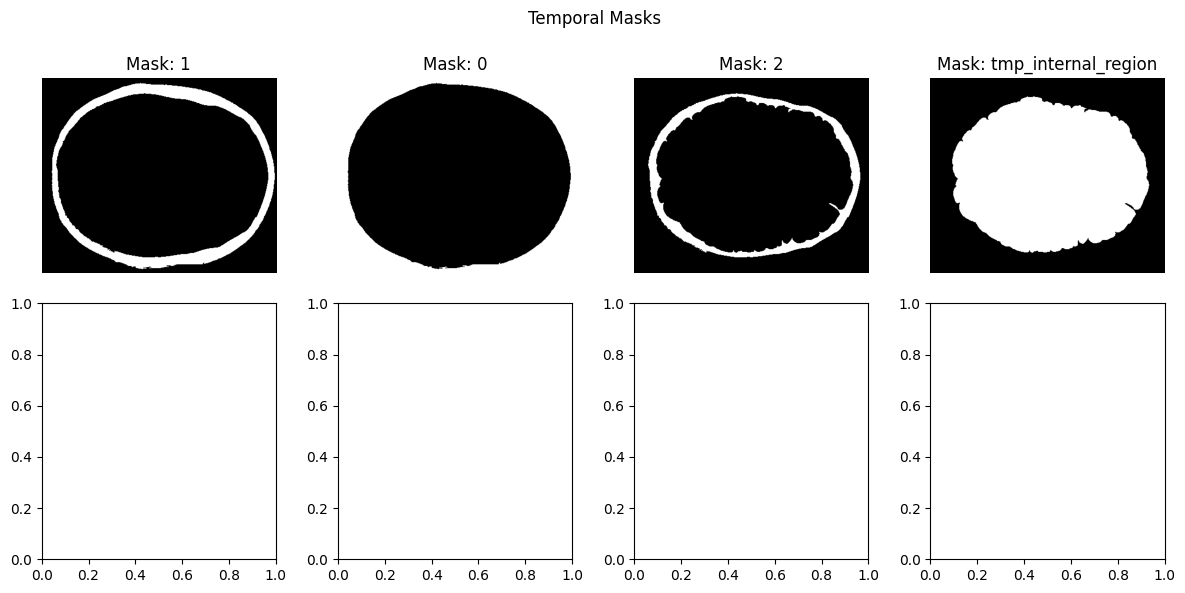

In [316]:
def four_mask_labeling(cleand, temporal_masks):
    # Apply two-pass algorithm to the cleaned image to have preliminary labels
    labels, _ = ndimage.label(cleaned)

    # NOTE: I got 3 labels, but I save only the first label
    # Save the temporal mask label 1
    temporal_masks["1"] = (labels == 1).astype(int)

    # Invert the cleaned image
    inverted = ~cleaned

    # Got the others labels from the inverted image
    # using the same two-pass algorithm
    inverted_labels, num_labels = ndimage.label(inverted)

    # Only consider the two first labels and all the other to zero
    inverted_labels[inverted_labels > 2] = 0

    # Save temporal masks label 0 and 2
    temporal_masks["0"] = (inverted_labels == 1).astype(int)
    temporal_masks["2"] = (inverted_labels == 2).astype(int)

    # Got the tmp internal region by considering all that is
    # not part of the mask 0, 1, 2
    tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
    temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

    return temporal_masks

temporal_masks = four_mask_labeling(cleaned, temporal_masks)

# Plot the temporal_mask in a unique img
keys = ["0", "1", "2", "tmp_internal_region"]
utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Four Masks Labeling")

# Plot temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4)


In [317]:
def internal_mask_refinement_convex_hull(temporal_masks):
    # Apply the convex hull to the tmo_internal_region
    binary_mask = convex_hull_image(temporal_masks["tmp_internal_region"])

    # Save the convex hull mask in the temporal masks
    temporal_masks["tmp_internal_region"] = binary_mask.astype(int)

    return binary_mask, temporal_masks

In [318]:
def internal_mask_refinement_morphological(temporal_masks):
    
    # Apply binary opening to the binary image
    binary_mask = binary_closing(temporal_masks["tmp_internal_region"], disk(2))

    # Fill holes in the binary image
    binary_mask = ndimage.binary_fill_holes(binary_mask)

    # Dilate the binary image
    binary_mask = ndimage.binary_dilation(binary_mask, disk(2))

    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

In [319]:
def internal_mask_refinement_edges(temporal_masks, reference_img):

    # Get the edges from masked internal region
    edges = canny(reference_img * temporal_masks["tmp_internal_region"])

    # Dilate the edges
    edges = ndimage.binary_dilation(edges)

    # Fill holes in the edges
    binary_mask = ndimage.binary_fill_holes(edges)

    # remove small objects
    binary_mask = remove_small_objects(binary_mask, min_size=100)

    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

In [296]:
def internal_mask_refinement(temporal_masks, reference_img, method):

    if method == 'convex_hull':
        return internal_mask_refinement_convex_hull(temporal_masks)
    elif method == 'morphological':
        return internal_mask_refinement_morphological(temporal_masks)
    elif method == 'edges':
        return internal_mask_refinement_edges(temporal_masks, reference_img)
        

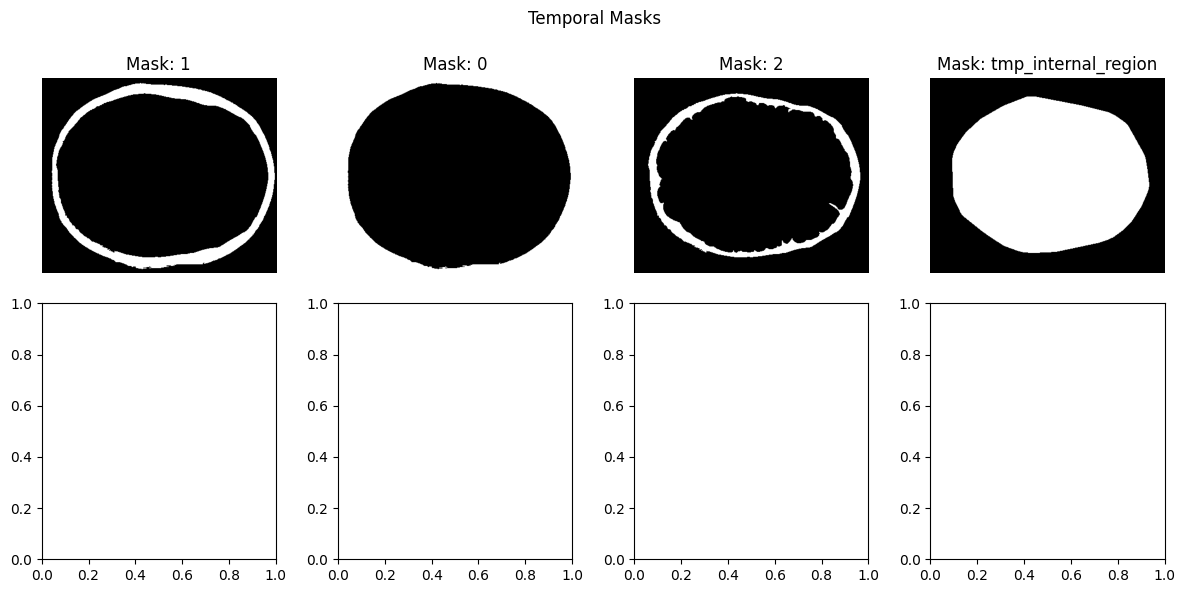

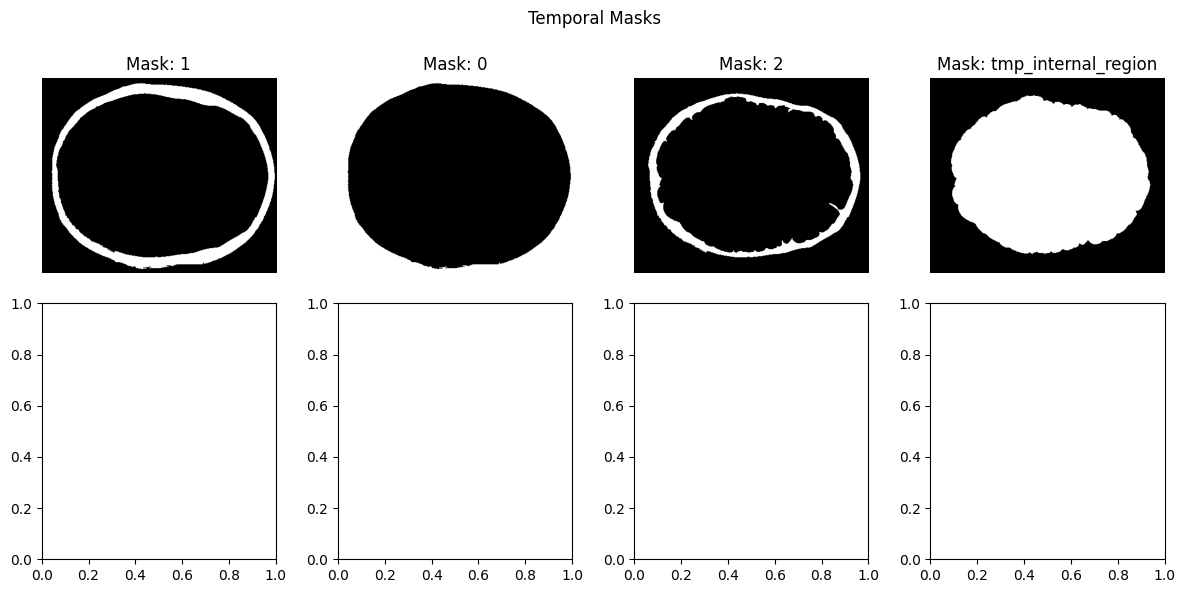

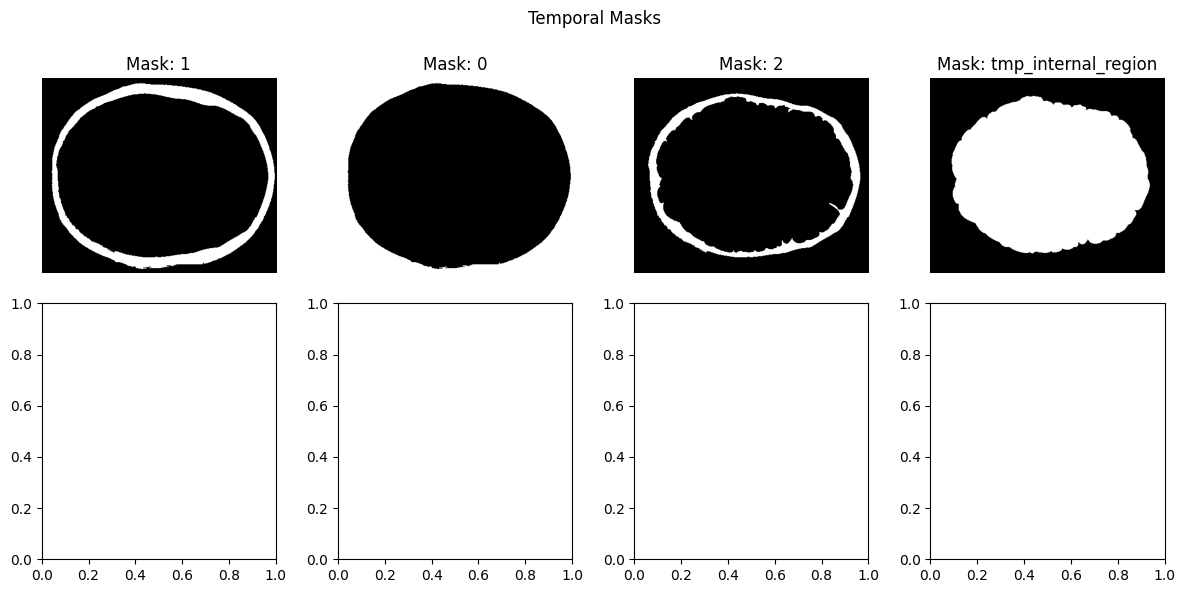

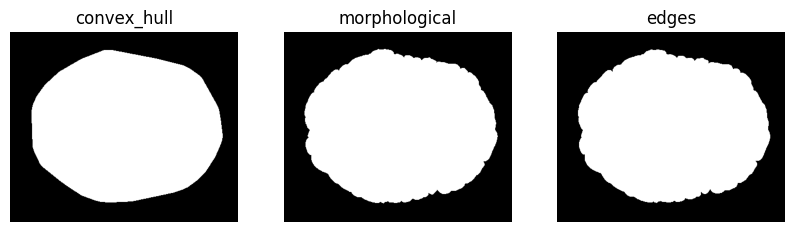

In [297]:
# Check each method
tmp_masks = []
methods = ['convex_hull', 'morphological', 'edges']

temporal_masks_copy = temporal_masks.copy()

for method in methods:
    binary_mask, _ = internal_mask_refinement(temporal_masks_copy, 
                                              reference_img,
                                              method=method)
    tmp_masks.append(binary_mask)

    # Plot the temporal masks
    utils.plot_masks(temporal_masks_copy, rows=2, cols=4)

    temporal_masks_copy = temporal_masks.copy()


        

utils.plot_images(
    tmp_masks,
    methods
)

In [321]:
utils.create_normal_distribution_mask(10, 4, 0, 1)

array([0.08164037, 0.09704389, 0.10979556, 0.11823737, 0.12119315,
       0.11823737, 0.10979556, 0.09704389, 0.08164037, 0.06537249])

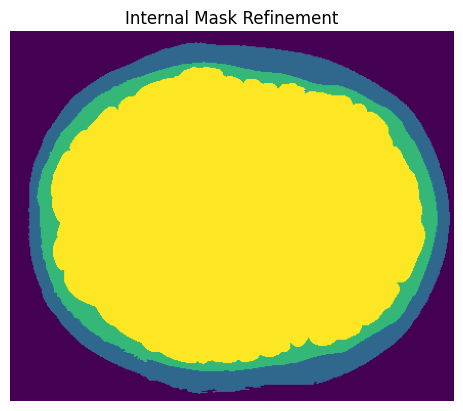

In [320]:
binary_mask, temporal_masks = internal_mask_refinement(temporal_masks, 
                                                       reference_img,
                                                       method='edges')

keys = ["0", "1", "2", "tmp_internal_region"]
segemented_img = utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Internal Mask Refinement")
# utils.plot_images(
#     [binary_mask, reference_img * binary_mask, segemented_img],
#     ['Convex Hull', 'Masked Convex Hull', 'Internal Mask Refinement'],
#     ['gray', 'gray', 'viridis']
# )

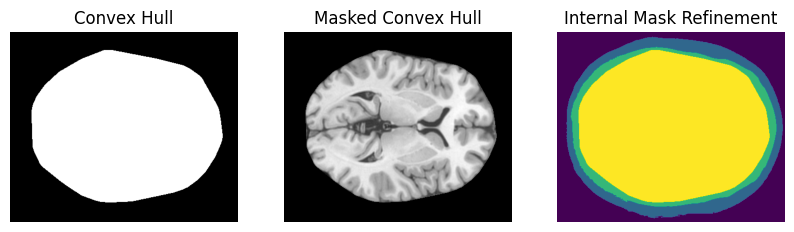

In [298]:
binary_mask, temporal_masks = internal_mask_refinement(temporal_masks, 
                                                       reference_img,
                                                       method='convex_hull')

keys = ["0", "1", "2", "tmp_internal_region"]
segemented_img = utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Internal Mask Refinement", isPlot = False)
utils.plot_images(
    [binary_mask, reference_img * binary_mask, segemented_img],
    ['Convex Hull', 'Masked Convex Hull', 'Internal Mask Refinement'],
    ['gray', 'gray', 'viridis']
)

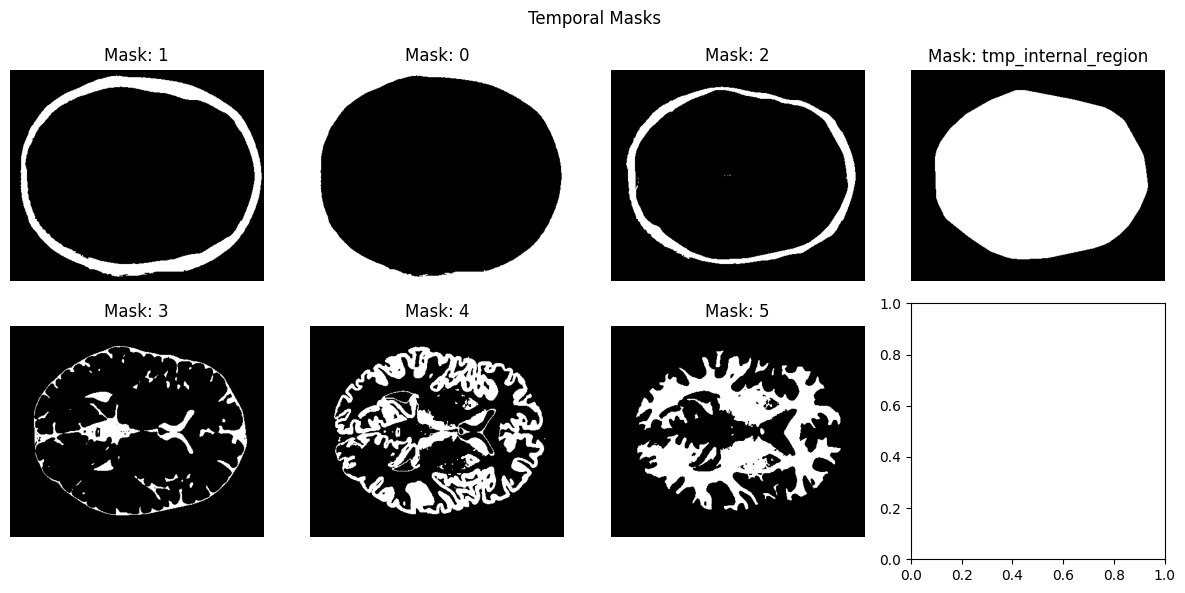

In [299]:
def internal_mask_labeling(temporal_masks, reference_img):
    # Apply the tmp_internal_region to the reference image
    masked_internal_region = reference_img * temporal_masks['tmp_internal_region']

    # Apply k-means clustering to the masked internal region
    internal_labels, order = utils.kmeans_segmentation(masked_internal_region, n_clusters=4)

    # Use the order to fit the mask 3, 4, 5
    # NOTE: I don't use order 0 because it corresponds to the external region
    temporal_masks["3"] = (internal_labels == order[1]).astype(int)
    temporal_masks["4"] = (internal_labels == order[2]).astype(int)
    temporal_masks["5"] = (internal_labels == order[3]).astype(int)

    # NOTE: There are certain difference between the convex hull 
    # and the internal region, which consequently affect the
    # k-means clustering, and mask 2. Then, I need to refine
    # the mask 2

    # Refine the mask 2 by considering all the others masks
    tmp_mask = ( temporal_masks["0"] + temporal_masks["1"] +
                temporal_masks["3"] + temporal_masks["4"] +
                temporal_masks["5"] )
    temporal_masks["2"] = (tmp_mask == 0).astype(int)

    return temporal_masks

temporal_masks = internal_mask_labeling(temporal_masks, reference_img)

# Plot the temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4)

In [300]:
# from skimage.segmentation import watershed

# def mask_1_2_refinement(reference_img, temporal_masks, threshold = 0.15):

#     # Load an example image
#     tmp_mask = (temporal_masks["1"] + temporal_masks["2"])
#     image = reference_img * tmp_mask

#     # Using a fixed threshold as markers for the watershed algorithm
#     markers = np.zeros_like(image)
#     markers[image <= threshold] = 1  # Markers for label 1
#     markers[image > threshold] = 2  # Markers for label 2

#     # Perform the watershed segmentation
#     segmentation = watershed(image, markers, mask = tmp_mask)

#     # Add the refined mask 1 and 2 to the temporal masks
#     temporal_masks["1"] = (segmentation == 1).astype(int)
#     temporal_masks["2"] = (segmentation == 2).astype(int)

#     return temporal_masks

# # utils.plot_masks(temporal_masks, 2, 4)

# temporal_masks = mask_1_2_refinement(reference_img, temporal_masks)

# # Plot the temporal masks
# utils.plot_masks(temporal_masks, 2, 4)

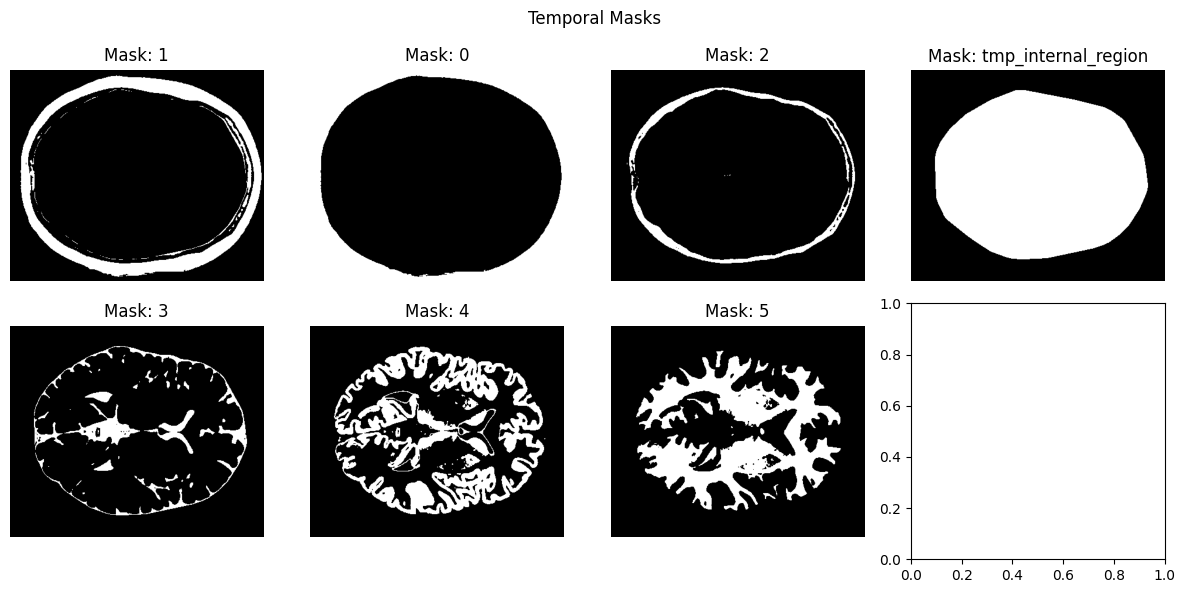

In [301]:
# NOTE: In the ground trues, the mask 1 and 2 have some
# parts in between each other. Then, I need to refine 
# these two masks

def mask_1_2_refinement(reference_img, temporal_masks, constant = 0.075):
    # Add the mask 1 and 2 in a tmp_mask
    tmp_mask = temporal_masks["1"] + temporal_masks["2"]

    # Apply tmp_mask to the reference image
    tmp_masked = reference_img * tmp_mask

    # Apply outsu algorithm to the masked image
    # NOTE: I add some constant value to the threshold
    # to improve the segmentation
    threshold = threshold_otsu(tmp_masked)
    binary = tmp_masked > threshold - constant

    # Add the refined mask 1 and 2 to the temporal masks
    temporal_masks["1"] = binary.astype(int)
    temporal_masks["2"] = tmp_mask - binary
    
    return temporal_masks

temporal_masks = mask_1_2_refinement(reference_img, temporal_masks)

# Plot the temporal masks
utils.plot_masks(temporal_masks, 2, 4)

Text(0.5, 1.0, 'Final Segmented Image')

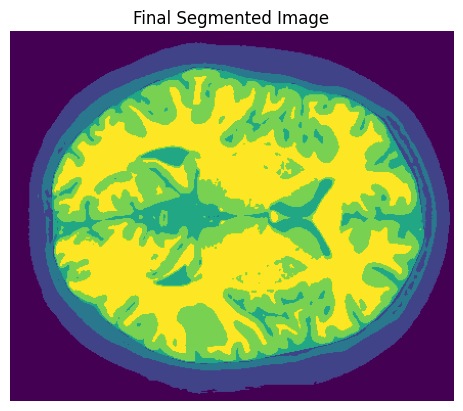

In [302]:
segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks)

# Plot the final segmented image
plt.imshow(segmented_img)
plt.axis('off')
plt.title('Final Segmented Image')

In [303]:
# Create a function to the whole process
def brain_segmentation(reference_img, temporal_masks, method,  constant =  0.075, baseline = False):

    temporal_masks = {}

    # Binarizing and cleaning the reference image
    cleaned = binarizing_cleaning(reference_img)

    # Apply the two-pass algorithm to the cleaned image
    temporal_masks = four_mask_labeling(cleaned, temporal_masks)

    if not baseline:
        # Refine the internal region by applying the convex hull
        binary_mask, temporal_masks = internal_mask_refinement(temporal_masks, 
                                                            reference_img,
                                                            method)

    # Apply k-means clustering to the internal region
    temporal_masks = internal_mask_labeling(temporal_masks, reference_img)

    if not baseline:
        # Refine the mask 1 and 2
        temporal_masks = mask_1_2_refinement(reference_img, temporal_masks, constant=constant)

    # Get the final segmented image
    segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks)

    return segmented_img, temporal_masks

In [304]:
segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'convex_hull')

# Show results
metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

print(metrics)
metrics_by_label


{'micro_jaccard': 0.9008, 'micro_dice': 0.9478, 'auprc': 0.94, 'micro_f1': 0.9478, 'accuracy': 0.9478}


{'jaccard label 0': 0.9517,
 'f1 label 0': 0.9752,
 'auprc label 0': 0.9759,
 'jaccard label 1': 0.8577,
 'f1 label 1': 0.9234,
 'auprc label 1': 0.9332,
 'jaccard label 2': 0.925,
 'f1 label 2': 0.961,
 'auprc label 2': 0.9626,
 'jaccard label 3': 0.7192,
 'f1 label 3': 0.8367,
 'auprc label 3': 0.8438,
 'jaccard label 4': 0.8821,
 'f1 label 4': 0.9374,
 'auprc label 4': 0.9528,
 'jaccard label 5': 0.9432,
 'f1 label 5': 0.9708,
 'auprc label 5': 0.9716}

In [305]:
segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'morphological')

# Show results
metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

print(metrics)
metrics_by_label


{'micro_jaccard': 0.9017, 'micro_dice': 0.9483, 'auprc': 0.9398, 'micro_f1': 0.9483, 'accuracy': 0.9483}


{'jaccard label 0': 0.9517,
 'f1 label 0': 0.9752,
 'auprc label 0': 0.9759,
 'jaccard label 1': 0.8567,
 'f1 label 1': 0.9228,
 'auprc label 1': 0.9329,
 'jaccard label 2': 0.9188,
 'f1 label 2': 0.9577,
 'auprc label 2': 0.9596,
 'jaccard label 3': 0.7186,
 'f1 label 3': 0.8363,
 'auprc label 3': 0.8436,
 'jaccard label 4': 0.8867,
 'f1 label 4': 0.94,
 'auprc label 4': 0.9546,
 'jaccard label 5': 0.9449,
 'f1 label 5': 0.9717,
 'auprc label 5': 0.9725}

In [306]:
segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'edges')

# Show results
metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

print(metrics)
metrics_by_label


{'micro_jaccard': 0.8954, 'micro_dice': 0.9448, 'auprc': 0.9365, 'micro_f1': 0.9448, 'accuracy': 0.9448}


{'jaccard label 0': 0.9517,
 'f1 label 0': 0.9752,
 'auprc label 0': 0.9759,
 'jaccard label 1': 0.8476,
 'f1 label 1': 0.9175,
 'auprc label 1': 0.9271,
 'jaccard label 2': 0.9371,
 'f1 label 2': 0.9675,
 'auprc label 2': 0.9686,
 'jaccard label 3': 0.6983,
 'f1 label 3': 0.8223,
 'auprc label 3': 0.8289,
 'jaccard label 4': 0.8748,
 'f1 label 4': 0.9332,
 'auprc label 4': 0.95,
 'jaccard label 5': 0.937,
 'f1 label 5': 0.9675,
 'auprc label 5': 0.9685}

### Testing correct constant value to refinem mask 1 and 2

In [307]:
results = {}

In [308]:
import pandas as pd

candidates = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

mean_per_candidate = []
std_per_candidate = []

for candidate_constant in candidates:

    # Create an empty dataframe
    df_metrics = pd.DataFrame()

    df_metrics_by_label = pd.DataFrame()

    for i in range(10):
        reference_img = mri_stacked[:,:,i]
        reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

        reference_labels = mri_labels[:,:,i]    

        segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'convex_hull', constant=candidate_constant)

        metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

        # metrics is a dictionary. Save as a row in the dataframe
        df_slice = pd.DataFrame(metrics, index=[i])
        df_metrics = df_metrics.append(df_slice)

        # metrics_by_label is a dictionary. Save as a row in the dataframe
        df_slice = pd.DataFrame(metrics_by_label, index=[i])
        df_metrics_by_label = df_metrics_by_label.append(df_slice)


    df_metrics.reset_index(drop=True, inplace=True)
    df_metrics_by_label.reset_index(drop=True, inplace=True)

    print(df_metrics['micro_jaccard'].mean())
    print(df_metrics['micro_jaccard'].std())

    mean_per_candidate.append(df_metrics['micro_jaccard'].mean())
    std_per_candidate.append(df_metrics['micro_jaccard'].std())
    
results["convex_hull"] = (mean_per_candidate, std_per_candidate)


0.90861
0.007551813615873285
0.9117899999999999
0.007896053866753109
0.9135800000000002
0.008379710947016937
0.91346
0.008907450065347915
0.91083
0.009384034905684817
0.90534
0.009854857798173565
0.89849
0.010381655830250684
0.88963
0.010210022309258462
0.8799300000000001
0.01028472978092601
0.86913
0.010669379863266043
0.85768
0.010998868628686804


In [309]:
import pandas as pd

candidates = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

mean_per_candidate = []
std_per_candidate = []

for candidate_constant in candidates:

    # Create an empty dataframe
    df_metrics = pd.DataFrame()

    df_metrics_by_label = pd.DataFrame()

    for i in range(10):
        reference_img = mri_stacked[:,:,i]
        reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

        reference_labels = mri_labels[:,:,i]    

        segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'morphological', constant=candidate_constant)

        metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

        # metrics is a dictionary. Save as a row in the dataframe
        df_slice = pd.DataFrame(metrics, index=[i])
        df_metrics = df_metrics.append(df_slice)

        # metrics_by_label is a dictionary. Save as a row in the dataframe
        df_slice = pd.DataFrame(metrics_by_label, index=[i])
        df_metrics_by_label = df_metrics_by_label.append(df_slice)


    df_metrics.reset_index(drop=True, inplace=True)
    df_metrics_by_label.reset_index(drop=True, inplace=True)

    print(df_metrics['micro_jaccard'].mean())
    print(df_metrics['micro_jaccard'].std())

    mean_per_candidate.append(df_metrics['micro_jaccard'].mean())
    std_per_candidate.append(df_metrics['micro_jaccard'].std())
    
results["morphological"] = (mean_per_candidate, std_per_candidate)


0.9067800000000001
0.006740227493687943
0.90991
0.007036168464915153
0.9116599999999998
0.007396425563142733


KeyboardInterrupt: 

In [ ]:
import pandas as pd

candidates = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

mean_per_candidate = []
std_per_candidate = []

for candidate_constant in candidates:

    # Create an empty dataframe
    df_metrics = pd.DataFrame()

    df_metrics_by_label = pd.DataFrame()

    for i in range(10):
        reference_img = mri_stacked[:,:,i]
        reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

        reference_labels = mri_labels[:,:,i]    

        segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'edges', constant=candidate_constant)

        metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

        # metrics is a dictionary. Save as a row in the dataframe
        df_slice = pd.DataFrame(metrics, index=[i])
        df_metrics = df_metrics.append(df_slice)

        # metrics_by_label is a dictionary. Save as a row in the dataframe
        df_slice = pd.DataFrame(metrics_by_label, index=[i])
        df_metrics_by_label = df_metrics_by_label.append(df_slice)


    df_metrics.reset_index(drop=True, inplace=True)
    df_metrics_by_label.reset_index(drop=True, inplace=True)

    print(df_metrics['micro_jaccard'].mean())
    print(df_metrics['micro_jaccard'].std())

    mean_per_candidate.append(df_metrics['micro_jaccard'].mean())
    std_per_candidate.append(df_metrics['micro_jaccard'].std())
    
results["edges"] = (mean_per_candidate, std_per_candidate)


0.9050699999999999
0.008069152509540403
0.9082600000000001
0.008442511474673878
0.9100100000000001
0.008846273540624642
0.9098599999999999
0.00934893933377829
0.9068900000000001
0.009760857202793873
0.90107
0.0102254638579925
0.8937900000000001
0.010535279356102096
0.88494
0.010337332559439333
0.87522
0.01034438119087954
0.8645099999999999
0.010765835881259863
0.8530599999999999
0.01106387514993429


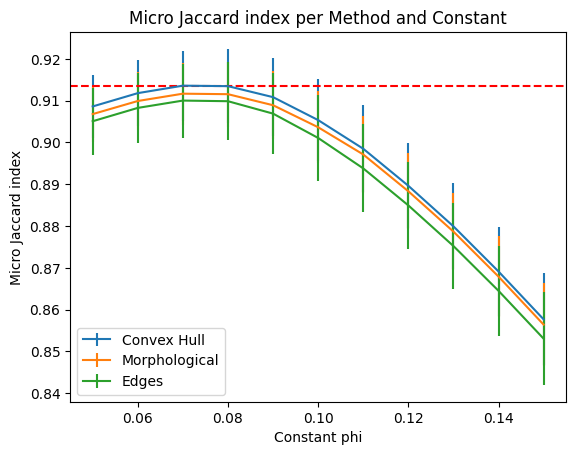

In [ ]:
# Plot the results per method in a single plot
plt.errorbar(candidates, results["convex_hull"][0], yerr=results["convex_hull"][1], label='Convex Hull')
plt.errorbar(candidates, results["morphological"][0], yerr=results["morphological"][1], label='Morphological')
plt.errorbar(candidates, results["edges"][0], yerr=results["edges"][1], label='Edges')
# plt.plot(candidates, results["convex_hull"][0], label='Convex Hull')
# plt.plot(candidates, results["morphological"][0], label='Morphological')
# plt.plot(candidates, results["edges"][0], label='Edges')
plt.xlabel('Constant phi')
plt.ylabel('Micro Jaccard index')
plt.legend()
plt.title('Micro Jaccard index per Method and Constant')

# Find the maximum value
max_value = max(max(results["convex_hull"][0]), max(results["morphological"][0]), max(results["edges"][0]))

# Plot the maximum value
plt.axhline(max_value, color='r', linestyle='--', label='Maximum')

plt.show()

### Baseline Results

In [ ]:
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

for i in range(10):
    reference_img = mri_stacked[:,:,i]
    reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

    reference_labels = mri_labels[:,:,i]    

    segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'convex_hull', baseline = True)

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [ ]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.8561,0.9225,0.8964,0.9225,0.9225
1,0.8630,0.9265,0.9034,0.9265,0.9265
2,0.8614,0.9255,0.9065,0.9255,0.9255
3,0.8599,0.9247,0.9062,0.9247,0.9247
4,0.8655,0.9279,0.9082,0.9279,0.9279
5,0.8663,0.9284,0.9084,0.9284,0.9284
6,0.8690,0.9299,0.9104,0.9299,0.9299
7,0.8713,0.9312,0.9097,0.9312,0.9312
8,0.8674,0.9290,0.9053,0.9290,0.9290
9,0.8653,0.9278,0.9035,0.9278,0.9278


In [ ]:
print(df_metrics.mean())
print(df_metrics.std())

micro_jaccard    0.86452
micro_dice       0.92734
auprc            0.90580
micro_f1         0.92734
accuracy         0.92734
dtype: float64
micro_jaccard    0.004514
micro_dice       0.002589
auprc            0.004072
micro_f1         0.002589
accuracy         0.002589
dtype: float64


In [ ]:
micro_jaccard    0.86452
micro_dice       0.92734
auprc            0.90580
accuracy         0.92734
dtype: float64
micro_jaccard    0.004514
micro_dice       0.002589
auprc            0.004072
accuracy         0.002589
dtype: float64

### Convex Hull results

In [ ]:
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

for i in range(10):
    reference_img = mri_stacked[:,:,i]
    reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

    reference_labels = mri_labels[:,:,i]    

    segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'convex_hull')

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [ ]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.9008,0.9478,0.9400,0.9478,0.9478
1,0.9071,0.9513,0.9448,0.9513,0.9513
2,0.9057,0.9505,0.9462,0.9505,0.9505
3,0.9057,0.9505,0.9459,0.9505,0.9505
4,0.9120,0.9540,0.9476,0.9540,0.9540
5,0.9164,0.9564,0.9489,0.9564,0.9564
6,0.9197,0.9582,0.9504,0.9582,0.9582
7,0.9236,0.9603,0.9506,0.9603,0.9603
8,0.9242,0.9606,0.9482,0.9606,0.9606
9,0.9228,0.9598,0.9456,0.9598,0.9598


In [ ]:
print(df_metrics.mean())
print(df_metrics.std())

micro_jaccard    0.91380
micro_dice       0.95494
auprc            0.94682
micro_f1         0.95494
accuracy         0.95494
dtype: float64
micro_jaccard    0.008661
micro_dice       0.004734
auprc            0.003114
micro_f1         0.004734
accuracy         0.004734
dtype: float64


In [ ]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9517,0.9752,0.9759,0.8577,0.9234,0.9332,0.9250,0.9610,0.9626,0.7192,0.8367,0.8438,0.8821,0.9374,0.9528,0.9432,0.9708,0.9716
1,0.9566,0.9778,0.9783,0.8688,0.9298,0.9389,0.9257,0.9614,0.9628,0.7423,0.8521,0.8590,0.8902,0.9419,0.9563,0.9467,0.9726,0.9734
2,0.9618,0.9805,0.9809,0.8823,0.9374,0.9454,0.9270,0.9621,0.9638,0.7572,0.8618,0.8685,0.8810,0.9368,0.9529,0.9317,0.9646,0.9658
3,0.9652,0.9823,0.9826,0.8903,0.9420,0.9495,0.9229,0.9599,0.9615,0.7523,0.8586,0.8658,0.8792,0.9357,0.9525,0.9276,0.9624,0.9638
4,0.9689,0.9842,0.9846,0.8998,0.9472,0.9536,0.9182,0.9574,0.9592,0.7436,0.8530,0.8611,0.8885,0.9410,0.9561,0.9420,0.9701,0.9710
5,0.9714,0.9855,0.9860,0.9080,0.9518,0.9573,0.9117,0.9538,0.9556,0.7452,0.8540,0.8624,0.8937,0.9439,0.9582,0.9478,0.9732,0.9739
6,0.9713,0.9854,0.9864,0.9148,0.9555,0.9605,0.8974,0.9459,0.9476,0.7646,0.8666,0.8737,0.8974,0.9459,0.9594,0.9501,0.9744,0.9751
7,0.9698,0.9847,0.9862,0.9215,0.9591,0.9635,0.8770,0.9345,0.9364,0.7682,0.8689,0.8757,0.9083,0.9520,0.9637,0.9569,0.9780,0.9784
8,0.9665,0.9830,0.9852,0.9265,0.9618,0.9657,0.8676,0.9291,0.9311,0.7379,0.8492,0.8577,0.9120,0.9540,0.9649,0.9690,0.9843,0.9845
9,0.9632,0.9812,0.9843,0.9263,0.9617,0.9653,0.8457,0.9164,0.9188,0.7328,0.8458,0.8544,0.9157,0.9560,0.9663,0.9697,0.9846,0.9848


In [ ]:
print(df_metrics_by_label.mean())
print(df_metrics_by_label.std())

### Morphological Results



In [ ]:
# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

for i in range(10):
    reference_img = mri_stacked[:,:,i]
    reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

    reference_labels = mri_labels[:,:,i]    

    segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'morphological')

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [ ]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.9017,0.9483,0.9398,0.9483,0.9483
1,0.9063,0.9509,0.9442,0.9509,0.9509
2,0.9026,0.9488,0.9442,0.9488,0.9488
3,0.9052,0.9502,0.9446,0.9502,0.9502
4,0.9116,0.9537,0.9461,0.9537,0.9537
5,0.9124,0.9542,0.9464,0.9542,0.9542
6,0.9179,0.9572,0.9483,0.9572,0.9572
7,0.9202,0.9584,0.9478,0.9584,0.9584
8,0.9209,0.9588,0.9453,0.9588,0.9588
9,0.9199,0.9583,0.9429,0.9583,0.9583


In [ ]:
print(df_metrics.mean())
print(df_metrics.std())

micro_jaccard    0.91187
micro_dice       0.95388
auprc            0.94496
micro_f1         0.95388
accuracy         0.95388
dtype: float64
micro_jaccard    0.007579
micro_dice       0.004146
auprc            0.002469
micro_f1         0.004146
accuracy         0.004146
dtype: float64


In [ ]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9517,0.9752,0.9759,0.8567,0.9228,0.9329,0.9188,0.9577,0.9596,0.7186,0.8363,0.8436,0.8867,0.9400,0.9546,0.9449,0.9717,0.9725
1,0.9566,0.9778,0.9783,0.8664,0.9284,0.9376,0.9217,0.9593,0.9610,0.7436,0.8529,0.8595,0.8913,0.9426,0.9567,0.9440,0.9712,0.9720
2,0.9618,0.9805,0.9809,0.8775,0.9347,0.9425,0.9251,0.9611,0.9630,0.7500,0.8571,0.8636,0.8776,0.9348,0.9516,0.9271,0.9622,0.9635
3,0.9652,0.9823,0.9826,0.8842,0.9386,0.9457,0.9218,0.9593,0.9611,0.7434,0.8528,0.8596,0.8821,0.9373,0.9535,0.9303,0.9639,0.9652
4,0.9689,0.9842,0.9846,0.8932,0.9436,0.9495,0.9146,0.9554,0.9576,0.7359,0.8478,0.8553,0.8919,0.9429,0.9574,0.9448,0.9716,0.9724
5,0.9714,0.9855,0.9860,0.8999,0.9473,0.9526,0.9063,0.9508,0.9530,0.7456,0.8542,0.8610,0.8901,0.9418,0.9567,0.9388,0.9684,0.9694
6,0.9713,0.9854,0.9864,0.9053,0.9503,0.9550,0.8954,0.9448,0.9467,0.7547,0.8602,0.8667,0.8983,0.9464,0.9597,0.9514,0.9751,0.9757
7,0.9698,0.9847,0.9862,0.9119,0.9539,0.9580,0.8754,0.9336,0.9356,0.7532,0.8592,0.8659,0.9055,0.9504,0.9626,0.9569,0.9780,0.9784
8,0.9665,0.9830,0.9852,0.9159,0.9561,0.9598,0.8609,0.9253,0.9274,0.7316,0.8450,0.8524,0.9112,0.9535,0.9645,0.9653,0.9824,0.9827
9,0.9632,0.9812,0.9843,0.9160,0.9562,0.9596,0.8417,0.9141,0.9165,0.7218,0.8384,0.8465,0.9147,0.9555,0.9660,0.9697,0.9846,0.9848


### Edges Results

In [ ]:


# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

for i in range(10):
    reference_img = mri_stacked[:,:,i]
    reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

    reference_labels = mri_labels[:,:,i]    

    segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'edges')

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [ ]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.8954,0.9448,0.9365,0.9448,0.9448
1,0.9035,0.9493,0.9411,0.9493,0.9493
2,0.9021,0.9485,0.9418,0.9485,0.9485
3,0.9027,0.9489,0.9416,0.9489,0.9489
4,0.9098,0.9527,0.9447,0.9527,0.9527
5,0.9119,0.9539,0.9456,0.9539,0.9539
6,0.9146,0.9554,0.9473,0.9554,0.9554
7,0.9221,0.9594,0.9485,0.9594,0.9594
8,0.9200,0.9584,0.9450,0.9584,0.9584
9,0.9201,0.9584,0.9433,0.9584,0.9584


In [ ]:
print(df_metrics.mean())
print(df_metrics.std())

micro_jaccard    0.86452
micro_dice       0.92734
auprc            0.90580
micro_f1         0.92734
accuracy         0.92734
dtype: float64
micro_jaccard    0.004514
micro_dice       0.002589
auprc            0.004072
micro_f1         0.002589
accuracy         0.002589
dtype: float64


In [ ]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9517,0.9752,0.9759,0.8476,0.9175,0.9271,0.9371,0.9675,0.9686,0.6983,0.8223,0.8289,0.8748,0.9332,0.9500,0.9370,0.9675,0.9685
1,0.9566,0.9778,0.9783,0.8570,0.9230,0.9317,0.9325,0.9651,0.9662,0.7151,0.8339,0.8404,0.8892,0.9413,0.9559,0.9483,0.9735,0.9742
2,0.9618,0.9805,0.9809,0.8685,0.9296,0.9370,0.9335,0.9656,0.9670,0.7180,0.8359,0.8429,0.8806,0.9365,0.9529,0.9398,0.9690,0.9699
3,0.9652,0.9823,0.9826,0.8757,0.9337,0.9406,0.9289,0.9631,0.9645,0.7128,0.8324,0.8398,0.8801,0.9362,0.9529,0.9386,0.9683,0.9693
4,0.9689,0.9842,0.9846,0.8853,0.9392,0.9449,0.9246,0.9608,0.9624,0.7239,0.8398,0.8468,0.8897,0.9416,0.9566,0.9462,0.9724,0.9731
5,0.9714,0.9855,0.9860,0.8942,0.9442,0.9491,0.9189,0.9577,0.9592,0.7288,0.8431,0.8501,0.8884,0.9409,0.9562,0.9463,0.9724,0.9732
6,0.9713,0.9854,0.9864,0.8962,0.9453,0.9494,0.9073,0.9514,0.9531,0.7537,0.8595,0.8650,0.8906,0.9422,0.9567,0.9464,0.9725,0.9732
7,0.9698,0.9847,0.9862,0.9081,0.9518,0.9556,0.8883,0.9409,0.9425,0.7424,0.8522,0.8590,0.9064,0.9509,0.9631,0.9691,0.9843,0.9845
8,0.9665,0.9830,0.9852,0.9112,0.9535,0.9570,0.8730,0.9322,0.9341,0.7246,0.8403,0.8471,0.9068,0.9511,0.9629,0.9680,0.9837,0.9840
9,0.9632,0.9812,0.9843,0.9119,0.9539,0.9571,0.8524,0.9203,0.9226,0.7215,0.8382,0.8451,0.9133,0.9547,0.9654,0.9711,0.9853,0.9856


In [ ]:
reference_labels = mri_labels

In [284]:
# Print the number of pixels per label
for i in range(6):
    print(f"Label {i}: {np.sum(mri_labels == i)} pixels")

# NOTE: clearly we have an imbalance in the number of pixels per label

Label 0: 426950 pixels
Label 1: 235461 pixels
Label 2: 93803 pixels
Label 3: 106140 pixels
Label 4: 384991 pixels
Label 5: 323735 pixels
